In [ ]:
import pandas as pd
df = pd.read_csv("/content/cervical-cancer_csv.csv")

Class counts -> cancer (Dx=0): 811, no cancer (Dx=1): 24


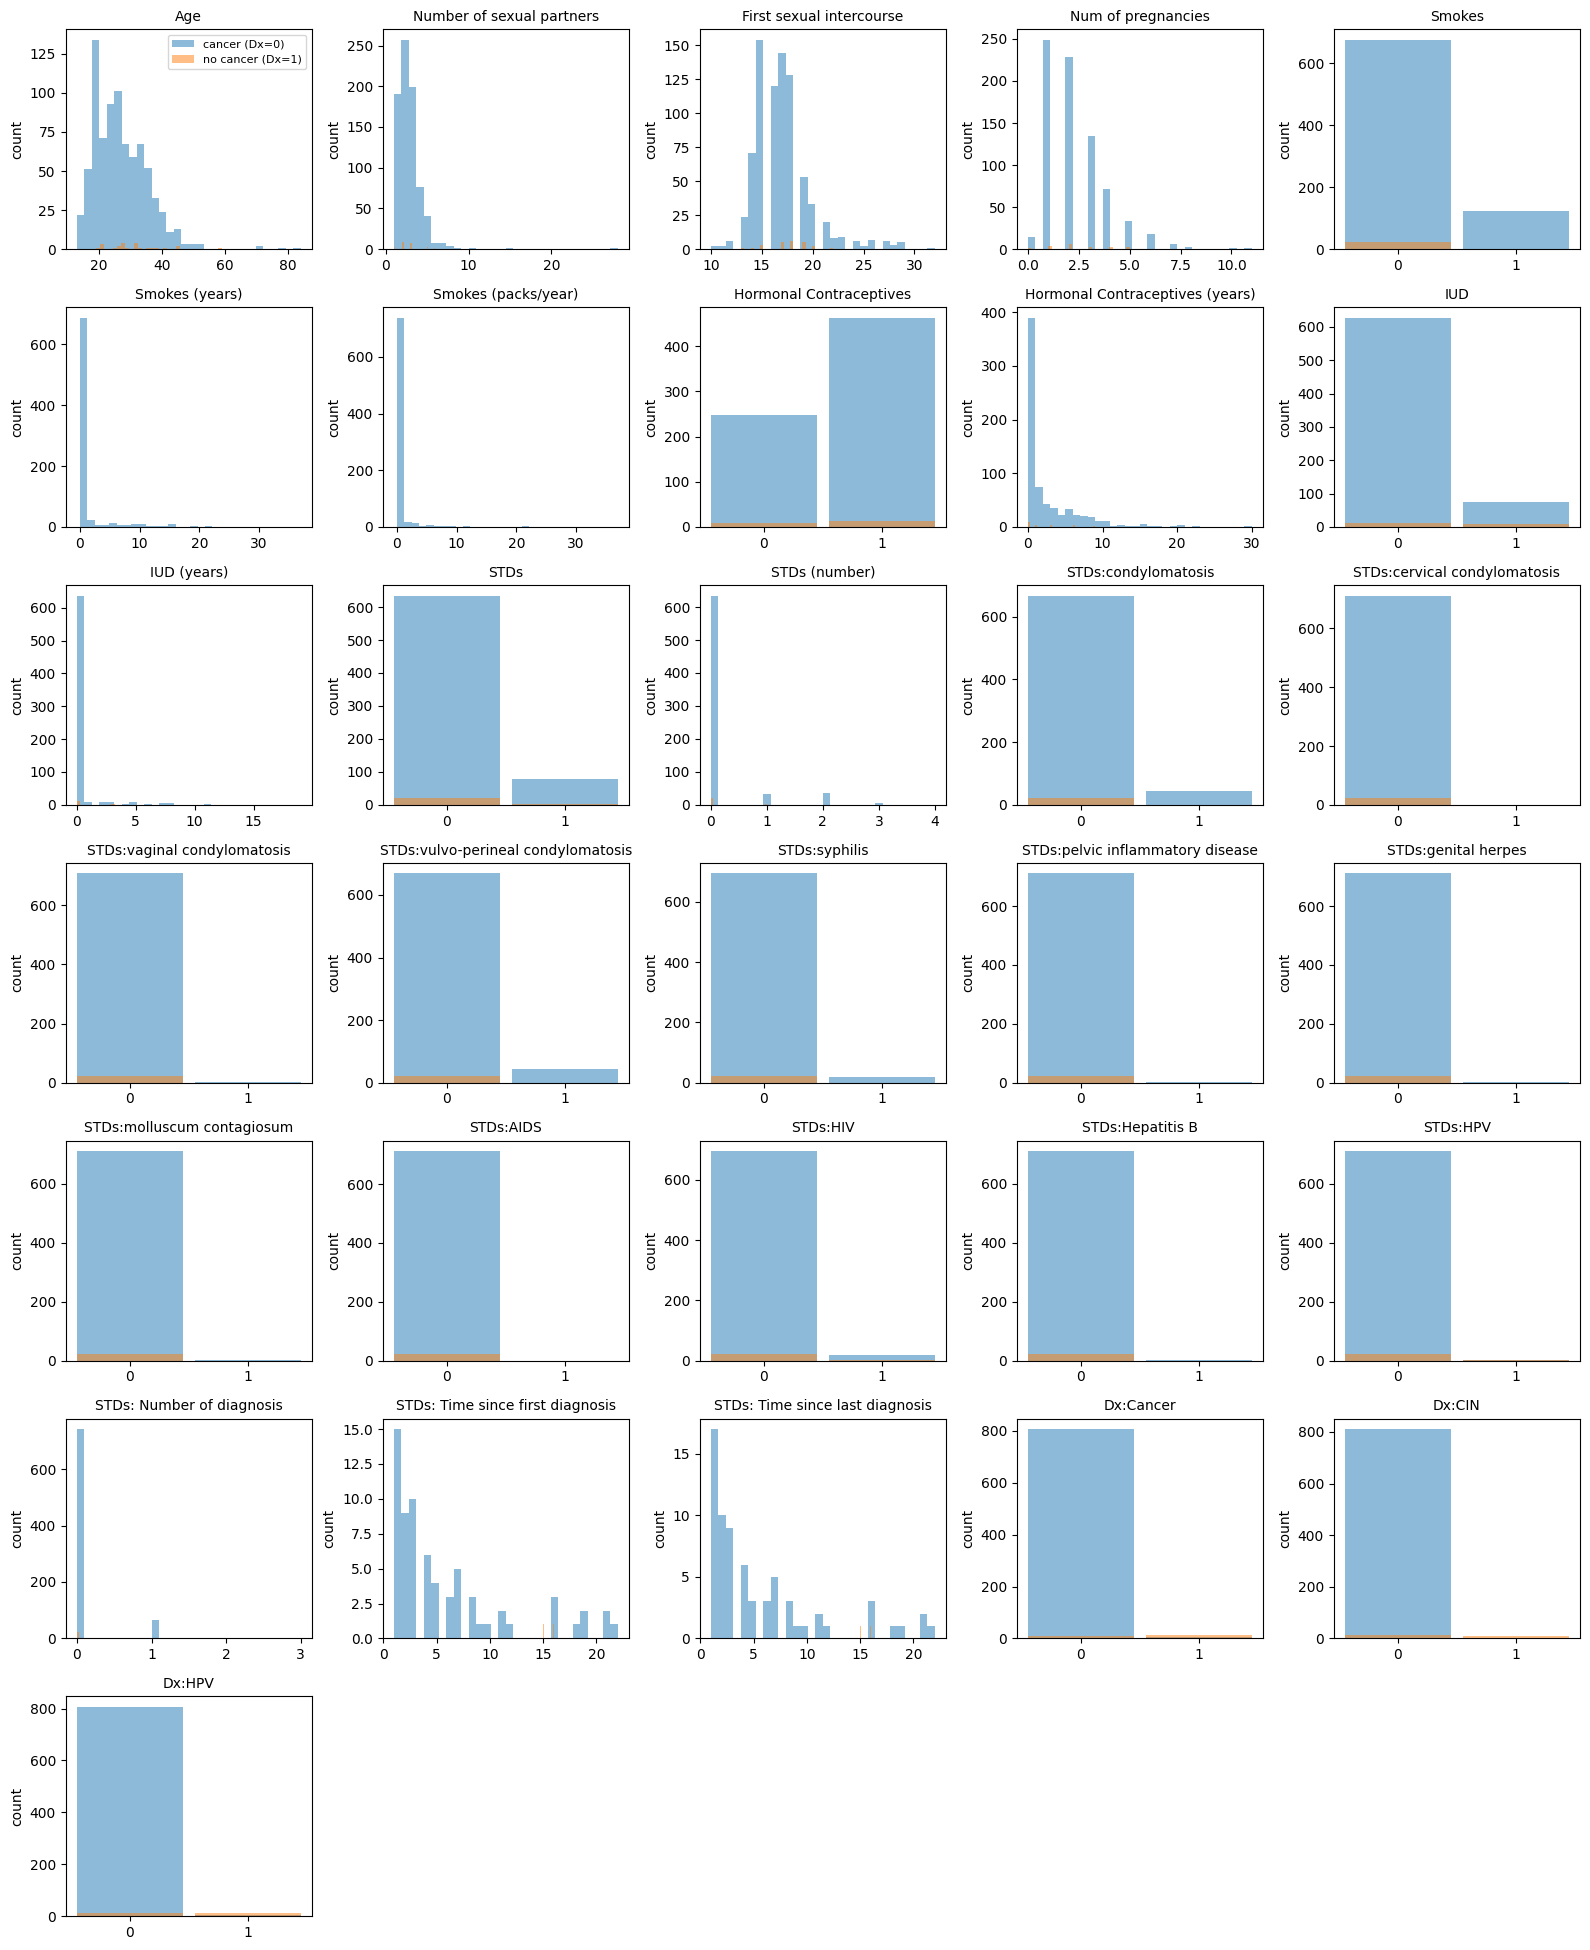

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# convert only object columns; coerce non-numeric to NaN
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Dx semantics: 0 => has cervical cancer, 1 => no cancer
if "Dx" not in df.columns:
    raise ValueError("Expected column 'Dx' not found.")
dx = pd.to_numeric(df["Dx"], errors="coerce")
has_cancer = dx.eq(0)
no_cancer  = dx.eq(1)
print(f"Class counts -> cancer (Dx=0): {has_cancer.sum()}, no cancer (Dx=1): {no_cancer.sum()}")

# plot all numeric features except Dx
numeric_cols = df.select_dtypes(include="number").columns.tolist()
if "Dx" in numeric_cols:
    numeric_cols.remove("Dx")
features = numeric_cols

def is_binary(s: pd.Series) -> bool:
    vals = pd.unique(s.dropna())
    return len(vals) <= 2 and set(vals).issubset({0, 1})

n_features = len(features)
n_cols = 5
n_rows = math.ceil(n_features / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.2, n_rows * 2.8))
ax = np.array(axes).ravel()

for i, col in enumerate(features):
    s = df[col]
    if s.dropna().empty:
        ax[i].set_visible(False)
        continue

    x_cancer = s[has_cancer].dropna().values
    x_nocan  = s[no_cancer].dropna().values
    if len(x_cancer) == 0 and len(x_nocan) == 0:
        ax[i].set_visible(False)
        continue

    if is_binary(s):
        bins = np.array([-0.5, 0.5, 1.5])
        ax[i].hist(x_cancer, bins=bins, alpha=0.5, label="cancer (Dx=0)", rwidth=0.9)
        ax[i].hist(x_nocan,  bins=bins, alpha=0.5, label="no cancer (Dx=1)", rwidth=0.9)
        ax[i].set_xticks([0, 1])
    else:
        ax[i].hist(x_cancer, bins=30, alpha=0.5, label="cancer (Dx=0)")
        ax[i].hist(x_nocan,  bins=30, alpha=0.5, label="no cancer (Dx=1)")

    ax[i].set_title(col, fontsize=10)
    ax[i].set_ylabel("count")
    if i == 0:
        ax[i].legend(fontsize=8, loc="best")

for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# ----------------
# Step 0: Imports
# ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [ ]:
# --------------------
# Step 1: Load Dataset
# --------------------
df = pd.read_csv(r"/content/cervical-cancer_csv.csv")
print("Original dataset shape:", df.shape)


Original dataset shape: (835, 32)


In [ ]:
# -------------------------------------------------
# Step 2: Identify Numeric and Categorical Columns
# -------------------------------------------------
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)


Numeric Columns: Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx'],
      dtype='object')
Categorical Columns: Index([], dtype='object')


In [ ]:
# ----------------------------------------------
# Step 3: Impute Missing Values
# ----------------------------------------------
method = "median"  # change to "knn" or "mice" if desired

# Numeric imputation
if len(numeric_cols) > 0:
    if method == "median":
        imputer = SimpleImputer(strategy='median')
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    elif method == "knn":
        imputer = KNNImputer(n_neighbors=5)
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    elif method == "mice":
        imputer = IterativeImputer(random_state=42)
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    else:
        raise ValueError("Invalid method selected")
else:
    print("No numeric columns for imputation.")

# Categorical imputation (fill missing with 'Missing')
if len(categorical_cols) > 0:
    df[categorical_cols] = df[categorical_cols].fillna("Missing")

# Check if any missing values remain
print("Remaining missing values per column:\n", df.isnull().sum())


Remaining missing values per column:
 Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
ST

In [ ]:
# ------------------------------------
# Step 4: Separate Features and Target
# ------------------------------------
y = df["Dx"]          # 0 = cancer, 1 = non-cancer
X = df.drop(columns=["Dx"])
# ------------------------------------------
# Step 5: Scale Features (important for PCA)
# ------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# -----------------------------
# Step 6: Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# ---------------------------------------------------
# Step 7: Train Random Forest with Class Weighting
# ---------------------------------------------------
clf = RandomForestClassifier(
    class_weight="balanced",  # automatically gives more weight to minority class
    n_estimators=200,
    random_state=42
)
clf.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
# Method 1: Training the Model using all the Features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Features and target
X = df.drop(columns=["Dx"])
y = df["Dx"]

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression
lr = LogisticRegression(
    class_weight="balanced",  # handle class imbalance
    max_iter=1000,            # increase iterations to ensure convergence
    random_state=42
)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       162
         1.0       0.80      0.80      0.80         5

    accuracy                           0.99       167
   macro avg       0.90      0.90      0.90       167
weighted avg       0.99      0.99      0.99       167

Confusion Matrix:
 [[161   1]
 [  1   4]]


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Feature correlations with Dx:
 Dx:Cancer                             0.665423
Dx:HPV                                0.616069
Dx:CIN                                0.606787
STDs:HPV                              0.138204
IUD                                   0.134500
IUD (years)                           0.099316
Age                                   0.089979
STDs: Time since last diagnosis       0.074900
STDs: Time since first diagnosis      0.073851
First sexual intercourse              0.034545
STDs:HIV                              0.023820
Number of sexual partners             0.022340
Num of pregnancies                    0.011144
STDs: Number of diagnosis            -0.003645
STDs:genital herpes                  -0.005957
STDs:Hepatitis B                     -0.005957
STDs:pelvic inflammatory disease     -0.005957
STDs:molluscum contagiosum           -0.005957
STDs                                 -0.006629
Hormonal Contraceptives              -0.010437
Hormonal Contraceptives (year

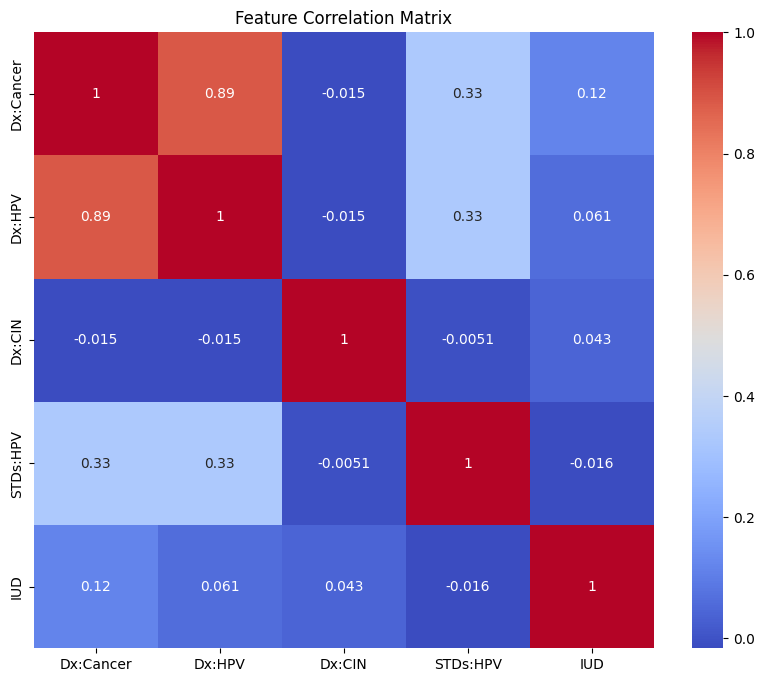

In [ ]:
#method 2: Training the Model using Reduced Features

# Make sure Dx is numeric
df["Dx"] = pd.to_numeric(df["Dx"], errors="coerce")

# Compute correlations of numeric features with Dx
numeric_cols = df.select_dtypes(include="number").columns.tolist()
if "Dx" in numeric_cols:
    numeric_cols.remove("Dx")  # exclude target itself

correlations = df[numeric_cols].corrwith(df["Dx"])
correlations = correlations.sort_values(ascending=False)
print("Feature correlations with Dx:\n", correlations)

# Keep only features with |correlation| >= 0.1
selected_features = correlations[correlations.abs() >= 0.1].index.tolist()
print("Selected features based on correlation:\n", selected_features)

X_selected = df[selected_features]
y = df["Dx"]

#Check Multicollinearity
import seaborn as sns

# Correlation matrix
corr_matrix = X_selected.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
#scale and train model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

lr = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       162
         1.0       0.80      0.80      0.80         5

    accuracy                           0.99       167
   macro avg       0.90      0.90      0.90       167
weighted avg       0.99      0.99      0.99       167

Confusion Matrix:
 [[161   1]
 [  1   4]]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=["Dx"])
y = df["Dx"]

# Train/test split BEFORE scaling/PCA
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline: Scaling -> PCA -> Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=6)),  # final number of components
    ('lr', LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
])

# Train
pipeline.fit(X_train, y_train)

# Predict & Evaluate
y_pred = pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       162
         1.0       0.83      1.00      0.91         5

    accuracy                           0.99       167
   macro avg       0.92      1.00      0.95       167
weighted avg       1.00      0.99      0.99       167

Confusion Matrix:
 [[161   1]
 [  0   5]]


In [ ]:
# PCA components
# Access the PCA object from the pipeline
pca_step = pipeline.named_steps['pca']
import pandas as pd

# Each row = one principal component
# Each column = original feature
loadings = pd.DataFrame(pca_step.components_, columns=X_train.columns, index=[f'PC{i+1}' for i in range(pca_step.n_components_)])

print(loadings)
for i in range(loadings.shape[0]):
    print(f"\nTop features for PC{i+1}:")
    print(loadings.iloc[i].abs().sort_values(ascending=False).head(5))



          Age  Number of sexual partners  First sexual intercourse  \
PC1  0.022409                   0.038402                  0.004777   
PC2  0.307134                   0.168577                 -0.000824   
PC3  0.283799                  -0.115864                  0.193856   
PC4  0.105075                  -0.070974                  0.027068   
PC5 -0.206222                  -0.078720                  0.064219   
PC6  0.224929                  -0.142228                  0.328958   

     Num of pregnancies    Smokes  Smokes (years)  Smokes (packs/year)  \
PC1            0.024095  0.096543        0.100923             0.061200   
PC2            0.273059  0.360200        0.458132             0.413430   
PC3            0.175185 -0.309923       -0.246990            -0.234653   
PC4            0.075889 -0.150155       -0.129386            -0.131011   
PC5           -0.294048 -0.119988       -0.121868            -0.041779   
PC6            0.153873 -0.114352       -0.097353            -0.0

Correlation of PCA components with Dx:
 PC1   -0.010661
PC2    0.226712
PC3    0.345577
PC4   -0.032753
PC5    0.500866
PC6   -0.026579
dtype: float64


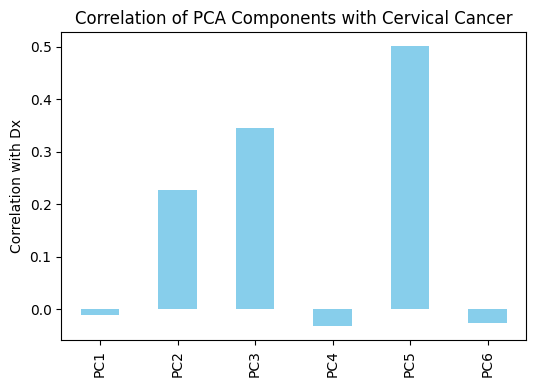

In [ ]:
# Get the PCA step from the pipeline
pca_step = pipeline.named_steps['pca']
scaler_step = pipeline.named_steps['scaler']

# Transform all X to PCA space
X_pca_full = pca_step.transform(scaler_step.transform(X))

# Convert to DataFrame for readability
import pandas as pd
X_pca_df = pd.DataFrame(X_pca_full, columns=[f'PC{i+1}' for i in range(X_pca_full.shape[1])])

correlations = X_pca_df.corrwith(y)
print("Correlation of PCA components with Dx:\n", correlations)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
correlations.plot(kind='bar', color='skyblue')
plt.ylabel("Correlation with Dx")
plt.title("Correlation of PCA Components with Cervical Cancer")
plt.show()


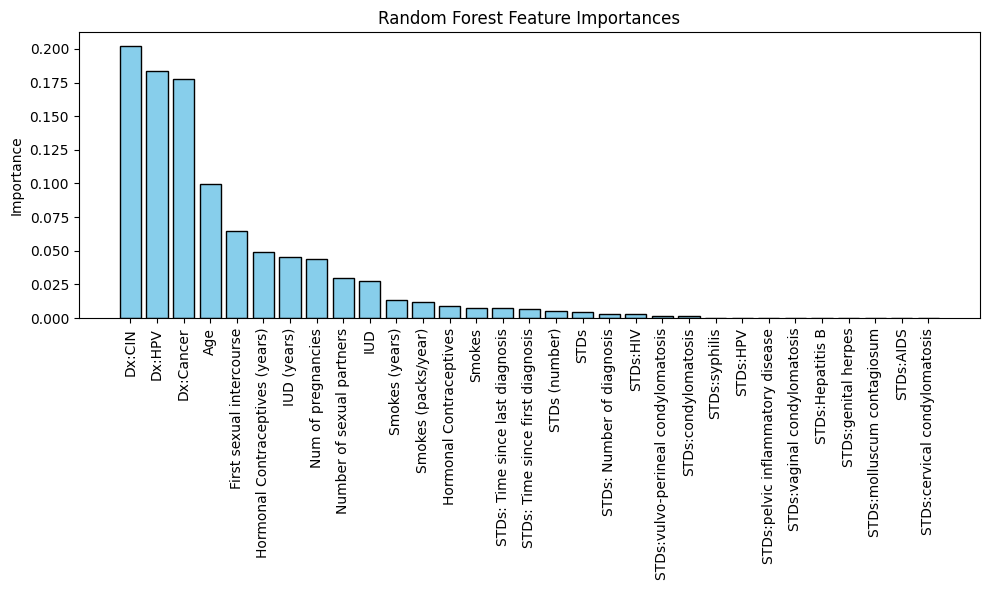

In [ ]:
# -----------------------------
# Step 10: Feature Importance
# -----------------------------
importances = clf.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]  # descending order

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices], color='skyblue', edgecolor='k')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
missing_data = df.isnull().sum()
print("Missing values in each column:\n", missing_data)

Missing values in each column:
 Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV

In [ ]:
X = df[[
    'Age',
    'Number of sexual partners',
    'First sexual intercourse',
    'Num of pregnancies',
    'Smokes',
    'Smokes (years)',
    'Smokes (packs/year)',
    'Hormonal Contraceptives',
    'Hormonal Contraceptives (years)',
    'IUD',
    'IUD (years)',
    'STDs',
    'STDs (number)',
    'STDs:condylomatosis',
    'STDs:cervical condylomatosis',
    'STDs:vaginal condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:pelvic inflammatory disease',
    'STDs:genital herpes',
    'STDs:molluscum contagiosum',
    'STDs:AIDS',
    'STDs:HIV',
    'STDs:Hepatitis B',
    'STDs:HPV',
    'STDs: Number of diagnosis'
]
]
y = df['Dx']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)
y_pred_new=[]
for i in y_pred:
    y_pred_new.append(100*(1-y_pred))

print(y_pred_new)

Streaming output truncated to the last 5000 lines.
        98.08503717, 101.26668628,  91.9649352 , 102.31491316,
        97.56842583,  90.73894549,  97.63911881,  97.25763591,
        96.09866751, 105.09931181,  94.76351188,  98.81905719,
        96.78515349,  97.11499143,  95.96175378,  99.03329123,
        97.81529188,  95.99163697,  99.06389726,  95.8826338 ,
        88.32030137,  96.46395254,  95.8149691 ,  97.34511614,
        89.69248145,  92.5829625 ,  89.50615028,  87.92285889,
       100.74956096,  98.0896862 ,  96.67248934,  91.49427394,
        99.35283312,  90.24028341,  99.09363702,  98.61479815,
       100.68339685,  93.50822707,  97.66819768,  93.46854099,
       102.78389329, 101.23901789,  98.88890262,  98.78691313,
       103.06557973, 107.90912565,  97.18830324,  99.26739016,
        96.11382974,  97.889417  ,  97.71922028,  96.80319006,
        99.79989209,  97.74984244,  95.1415323 ,  97.6890827 ,
        95.67725717,  97.03931234,  90.61871356,  95.43155076,
    